# Fast BART

## Imports

In [42]:
import os
import numpy as np
from matplotlib import pyplot as plt
from time import perf_counter as pc

In [43]:
from fastBart import (OnnxBart, get_onnx_runtime_sessions,
                    generate_onnx_representation, quantize,get_onnx_model,export_and_get_onnx_model)
from fastBart.model_testing_tools import speed_test

In [44]:
from transformers import AutoTokenizer, BartForConditionalGeneration

## Constants

In [4]:
model_name = 'facebook/bart-base'
custom_output_path = "./models-bart/"

## Step-wise Pytorch to Onnx with Quantization

### 1. Coverting model from pytorch to Onnx

In [5]:
%%time
onnx_model_paths = generate_onnx_representation(model_name)

Exporting to onnx... |################################| 3/3

CPU times: user 18.6 s, sys: 8.33 s, total: 27 s
Wall time: 27.6 s


### 2. Quantize the ONNX model

In [6]:
%%time
quant_model_paths = quantize(onnx_model_paths)

Quantizing... |################################| 3/3

CPU times: user 9min 15s, sys: 6min 13s, total: 15min 29s
Wall time: 15min 37s


    Quantization for the decoder, and init-decoder are a bit slow. It can take a few minutes to complete.

### 3. Setup Onnx Runtime session

In [7]:
model_sessions = get_onnx_runtime_sessions(quant_model_paths)

### 4. Load the model

In [8]:
model = OnnxBart(model_name, model_sessions)

## Unified Pipeline

In [9]:
# model = export_and_get_onnx_model(model_name,custom_output_path)

## Loading Pre-converted models

In [ ]:
# name = 'bart-base'

# quant_model_paths = [os.path.join(custom_output_path,name+"-"+x) for x in ['encoder-quantized.onnx','decoder-quantized.onnx','init-decoder-quantized.onnx']]
# quant_model_paths = tuple(quant_model_paths)
# quant_model_paths

In [ ]:
# model_sessions = get_onnx_runtime_sessions(quant_model_paths)
# model = OnnxBart(model_name, model_sessions)

## Model Performance

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
pytorch_model = BartForConditionalGeneration.from_pretrained(model_name)

## Processing

### Constants

In [20]:
max_input_length = 256
max_target_length = 128

### Predictions

In [21]:
text = """Since being shared on Reddit, the 21-second video has garnered more than 35,000 upvotes. People also filled the comment section with adorable comments.
A Reddit user said that he liked the little cat staring at the mama dog for a moment. Another liked the calmness and patience of the mama dog.
“This is soooo cute,” commented a third Reddit user. Many users also added that humans should learn kindness from these animals.
Well, this is not the first time that a kitten was feeding on a nursing dog.Last year, a similar heartwarming video had surfaced \
from a remote village in Nigeria that showed a little feline feeding on milk from a mama dog. The clip, which had gone viral, has \
so far accumulated over 1 million views. Twitter users showered love for the dog and the little kitten.The 32-second clip was shared \
by Reuters on its official Twitter handle with the caption, “It's a most unusual sight: a kitten was spotted feeding on milk from a nursing dog in a remote village in Nigeria.”
"""

In [23]:
%%time

inputs = tokenizer(text, max_length=max_input_length, return_tensors='pt')

# Generate summaries
output_sequences = model.generate(input_ids=inputs['input_ids'],max_length=max_target_length,num_beams=3)
generated_text = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)[0]

print('INPUT:\n', text,'\n')
print('SUMMARY:\n', generated_text,'\n')

INPUT:
 Since being shared on Reddit, the 21-second video has garnered more than 35,000 upvotes. People also filled the comment section with adorable comments.
A Reddit user said that he liked the little cat staring at the mama dog for a moment. Another liked the calmness and patience of the mama dog.
“This is soooo cute,” commented a third Reddit user. Many users also added that humans should learn kindness from these animals.
Well, this is not the first time that a kitten was feeding on a nursing dog.Last year, a similar heartwarming video had surfaced from a remote village in Nigeria that showed a little feline feeding on milk from a mama dog. The clip, which had gone viral, has so far accumulated over 1 million views. Twitter users showered love for the dog and the little kitten.The 32-second clip was shared by Reuters on its official Twitter handle with the caption, “It's a most unusual sight: a kitten was spotted feeding on milk from a nursing dog in a remote village in Nigeria.”

### Onnx vs Pytorch

#### Size Comparison

Pytorch-model size : 532M

In [41]:
!cd "$custom_output_path";du -sh *

123M	bart-base-decoder-quantized.onnx
487M	bart-base-decoder.onnx
 79M	bart-base-encoder-quantized.onnx
313M	bart-base-encoder.onnx
130M	bart-base-init-decoder-quantized.onnx
514M	bart-base-init-decoder.onnx


    Pytorch file size        : 532M
    Onnx file size           : 1314M
    Quantized-Onnx file size : 332M

#### Performance Comparison

seqL : 32, onnx-0.34127084000010655, pt-0.9822839859998567 .. X faster 2.8783120937011497
seqL : 64, onnx-0.7009542420000798, pt-1.952082222000172 .. X faster 2.784892515137885
seqL : 96, onnx-1.1063281910001024, pt-2.8521081569997477 .. X faster 2.5779946495094634
seqL : 128, onnx-1.596302587000082, pt-3.8603175560001546 .. X faster 2.418286850774838
seqL : 160, onnx-2.1618258519997653, pt-4.916804455000147 .. X faster 2.274375824700185
seqL : 192, onnx-2.7556150200002776, pt-5.969720664999841 .. X faster 2.1663841362714154
seqL : 224, onnx-3.440460626999993, pt-7.074772848000066 .. X faster 2.0563446628276383
seqL : 256, onnx-4.293022999000186, pt-8.349490481999965 .. X faster 1.9448976825757747
seqL : 288, onnx-5.5322495119999076, pt-9.785055285999988 .. X faster 1.768729928896987
seqL : 320, onnx-6.196998977000021, pt-10.476615106999816 .. X faster 1.690594938918574
seqL : 352, onnx-7.2578672099998585, pt-11.617871215999912 .. X faster 1.600727993478974
seqL : 384, onnx-8.904296129

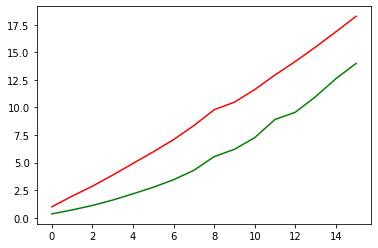

seqL : 32, onnx-0.46369721000019126, pt-1.6887113879997742 .. X faster 3.641840734817183
seqL : 64, onnx-1.1263507030002984, pt-3.39527311799975 .. X faster 3.0144013840055734
seqL : 96, onnx-1.7673246149997794, pt-5.328860513000109 .. X faster 3.0152132029241123
seqL : 128, onnx-2.800090538999939, pt-7.3397087390003435 .. X faster 2.6212397909182408
seqL : 160, onnx-3.9450914770000054, pt-9.245858105000025 .. X faster 2.3436359229953574
seqL : 192, onnx-5.419562043000042, pt-11.42960538000034 .. X faster 2.108953692072393
seqL : 224, onnx-6.6991191440001785, pt-13.6385407570001 .. X faster 2.035870756114998
seqL : 256, onnx-8.399791871999696, pt-15.509736858999986 .. X faster 1.84644299470097
seqL : 288, onnx-10.481821465999928, pt-17.773101254000267 .. X faster 1.6956119040618267
seqL : 320, onnx-12.287066529000185, pt-20.043529196000236 .. X faster 1.631270502905888
seqL : 352, onnx-14.734283799999957, pt-22.852507305000017 .. X faster 1.5509751010089872
seqL : 384, onnx-17.17826829

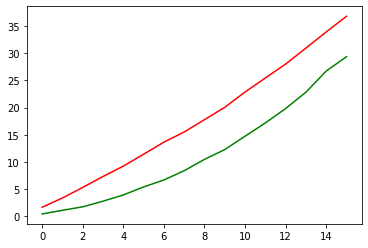

seqL : 32, onnx-0.5648669500001233, pt-1.7262365869996756 .. X faster 3.0560056434516105
seqL : 64, onnx-1.2210942169999726, pt-3.468513499999972 .. X faster 2.8404962137332355
seqL : 96, onnx-2.145441765999749, pt-5.421016038000289 .. X faster 2.5267598141840795
seqL : 128, onnx-3.4464136199999302, pt-7.514903835000041 .. X faster 2.1804996914445205
seqL : 160, onnx-4.936816227000236, pt-9.63552350000009 .. X faster 1.9517687223806053
seqL : 192, onnx-6.749549762999777, pt-11.92293889099983 .. X faster 1.766479144484563
seqL : 224, onnx-8.886433143999966, pt-14.351342556999953 .. X faster 1.614972208133906
seqL : 256, onnx-11.37731974799999, pt-16.808688419999726 .. X faster 1.4773856050722765
seqL : 288, onnx-14.747921714000313, pt-19.68354844500027 .. X faster 1.3346659161008787
seqL : 320, onnx-17.89758284399977, pt-22.42313549299979 .. X faster 1.2528583154745518
seqL : 352, onnx-21.13018205799972, pt-25.087827348000246 .. X faster 1.187298210641881
seqL : 384, onnx-23.04734937000

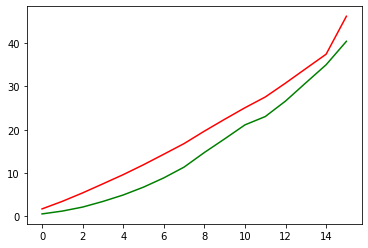

seqL : 32, onnx-0.5554251790003946, pt-1.802158953000344 .. X faster 3.2446475621499755
seqL : 64, onnx-1.391706391000298, pt-3.7379983800001355 .. X faster 2.6859101921012414
seqL : 96, onnx-2.6759656979998, pt-5.863696394999806 .. X faster 2.1912449772367166
seqL : 128, onnx-4.512203946000227, pt-8.16305226500026 .. X faster 1.8091053424649104
seqL : 160, onnx-6.370190445999924, pt-10.750313889000154 .. X faster 1.6875969376630913
seqL : 192, onnx-8.917611648000275, pt-13.166227227000036 .. X faster 1.4764297601984595
seqL : 224, onnx-11.630706315000225, pt-15.981335811999998 .. X faster 1.3740640833986777
seqL : 256, onnx-14.849336220999703, pt-18.860539195 .. X faster 1.2701267527586666
seqL : 288, onnx-18.77789818500014, pt-22.311234518999754 .. X faster 1.1881646337193401
seqL : 320, onnx-23.112617804000365, pt-25.42247272700024 .. X faster 1.0999391303307964
seqL : 352, onnx-27.599169621999863, pt-28.96336316299994 .. X faster 1.0494287893325838
seqL : 384, onnx-33.1595187059997

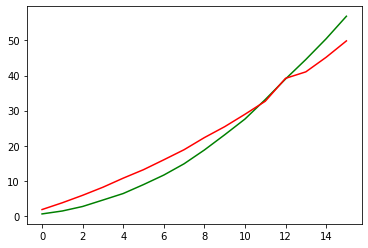

(array([[ 0.34127084,  0.70095424,  1.10632819,  1.59630259,  2.16182585,
          2.75561502,  3.44046063,  4.293023  ,  5.53224951,  6.19699898,
          7.25786721,  8.90429613,  9.55719587, 10.97369863, 12.60021922,
         13.99117729],
        [ 0.46369721,  1.1263507 ,  1.76732461,  2.80009054,  3.94509148,
          5.41956204,  6.69911914,  8.39979187, 10.48182147, 12.28706653,
         14.7342838 , 17.1782683 , 19.81467652, 22.82344204, 26.69881157,
         29.34133463],
        [ 0.56486695,  1.22109422,  2.14544177,  3.44641362,  4.93681623,
          6.74954976,  8.88643314, 11.37731975, 14.74792171, 17.89758284,
         21.13018206, 23.04734937, 26.63090141, 30.84411991, 35.01199873,
         40.42947847],
        [ 0.55542518,  1.39170639,  2.6759657 ,  4.51220395,  6.37019045,
          8.91761165, 11.63070632, 14.84933622, 18.77789819, 23.1126178 ,
         27.59916962, 33.15951871, 39.02105102, 44.57874585, 50.48125309,
         56.90994586]]),
 array([[ 0.982283

In [45]:
speed_test(model, pytorch_model, range(1, 5, 1), range(32, 544, 32))